In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
from torchvision import models
from sklearn.utils import shuffle
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.checkpoint import checkpoint_sequential
from torch.cuda.amp import autocast, GradScaler
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchinfo
import random  # Add this import statement at the top of your script
from torch.utils.checkpoint import checkpoint


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import torch.optim.lr_scheduler as lr_scheduler

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dataset

In [4]:
random_seeds = [42, 50, 2024]  # List of seeds for reproducibility


In [5]:
import os

# Directory for the actual dataset (ignoring the __MACOSX folder)
print("Input Files Directory")
print(os.listdir('/kaggle/input/food-101/food-101'))

# Directory for the meta files (ignoring the __MACOSX folder)
print("Input Input Files Directory")
print(os.listdir('/kaggle/input/food-101/food-101/food-101'))

# Directory for the meta files (ignoring the __MACOSX folder)
print("Input Input Files Directory")
print(os.listdir('/kaggle/input/food-101/food-101/food-101/meta'))

Input Files Directory
['__MACOSX', 'food-101']
Input Input Files Directory
['meta', 'README.txt', 'images', 'license_agreement.txt', '.DS_Store']
Input Input Files Directory
['test.txt', 'train.json', 'labels.txt', 'test.json', 'train.txt', 'classes.txt']


## Classes

Note that the original labels have 101 classes. In our project, we only have 21 classes, with an "other" class covering everything not in the first 20 classes.

In [6]:
classes = open("/kaggle/input/food-101/food-101/food-101/meta/classes.txt", 'r').read().splitlines()
classes_21 = classes[:20] + ['other']
classes_21, len(classes_21)

(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheesecake',
  'cheese_plate',
  'chicken_curry',
  'chicken_quesadilla',
  'other'],
 21)

## Identifying testing and training images
The testing and training images are all in the ../input/food-101/food-101/food-101/images/ folder, identifying the test and the training images is done by reading the test.txt and train.txt files in the meta folder

In [7]:
print("Testing images")
with open("/kaggle/input/food-101/food-101/food-101/meta/test.txt") as f:
    temp = f.read().splitlines()
    for i in range(5):
        print(f"\t{temp[i]}")

print("\nTraining images")
with open("/kaggle/input/food-101/food-101/food-101/meta/train.txt") as f:
    temp = f.read().splitlines()
    for i in range(5):
        print(f"\t{temp[i]}")

Testing images
	apple_pie/1011328
	apple_pie/101251
	apple_pie/1034399
	apple_pie/103801
	apple_pie/1038694

Training images
	apple_pie/1005649
	apple_pie/1014775
	apple_pie/1026328
	apple_pie/1028787
	apple_pie/1043283


Exploratory Data Analysis Creation of a Dataframe that contains information about the dataset

## class Label_encoder

In [8]:
class Label_encoder:
    def __init__(self, labels):
        self.labels = {label: idx for idx, label in enumerate(labels)}

    def get_label(self, idx):
        return list(self.labels.keys())[idx]

    def get_idx(self, label):
        return self.labels.get(label)

encoder_21 = Label_encoder(classes_21)
encoder_21.get_label(0), encoder_21.get_idx( encoder_21.get_label(0) )

for i in range(21):
    print(encoder_21.get_label(i), encoder_21.get_idx( encoder_21.get_label(i) ))

apple_pie 0
baby_back_ribs 1
baklava 2
beef_carpaccio 3
beef_tartare 4
beet_salad 5
beignets 6
bibimbap 7
bread_pudding 8
breakfast_burrito 9
bruschetta 10
caesar_salad 11
cannoli 12
caprese_salad 13
carrot_cake 14
ceviche 15
cheesecake 16
cheese_plate 17
chicken_curry 18
chicken_quesadilla 19
other 20


In [9]:
def prep_df(path: str) -> pd.DataFrame:
    array = open(path, 'r').read().splitlines()

    # Getting the full path for the images
    img_path = "/kaggle/input/food-101/food-101/food-101/images/"
    full_path = [img_path + img + ".jpg" for img in array]

    # Splitting the image index from the label
    imgs = []
    for img in array:
        img = img.split('/')

        imgs.append(img)

    imgs = np.array(imgs)

    for idx, img in enumerate(imgs):
        if encoder_21.get_idx(img[0]) is None:
            imgs[idx, 0] = "other"
    
    # Converting the array to a data frame
    imgs = pd.DataFrame(imgs[:, 0], imgs[:,1], columns=['label'])
            
    # Adding the full path to the data frame
    imgs['path'] = full_path

    # Randomly shuffling the order of the data in the dataframe
    imgs = shuffle(imgs)

    return imgs

In [10]:
train_imgs = prep_df('/kaggle/input/food-101/food-101/food-101/meta/train.txt')
test_imgs = prep_df('/kaggle/input/food-101/food-101/food-101/meta/test.txt')

train_imgs.groupby(["label"]).count()

,path
label,
apple_pie,750
baby_back_ribs,750
baklava,750
beef_carpaccio,750
beef_tartare,750
beet_salad,750
beignets,750
bibimbap,750
bread_pudding,750


From the randomly sampled images below it could be noticed that due to the formulation of the problem there is a class imbalance towards the "other" class which ends at the character "C" alphabetically

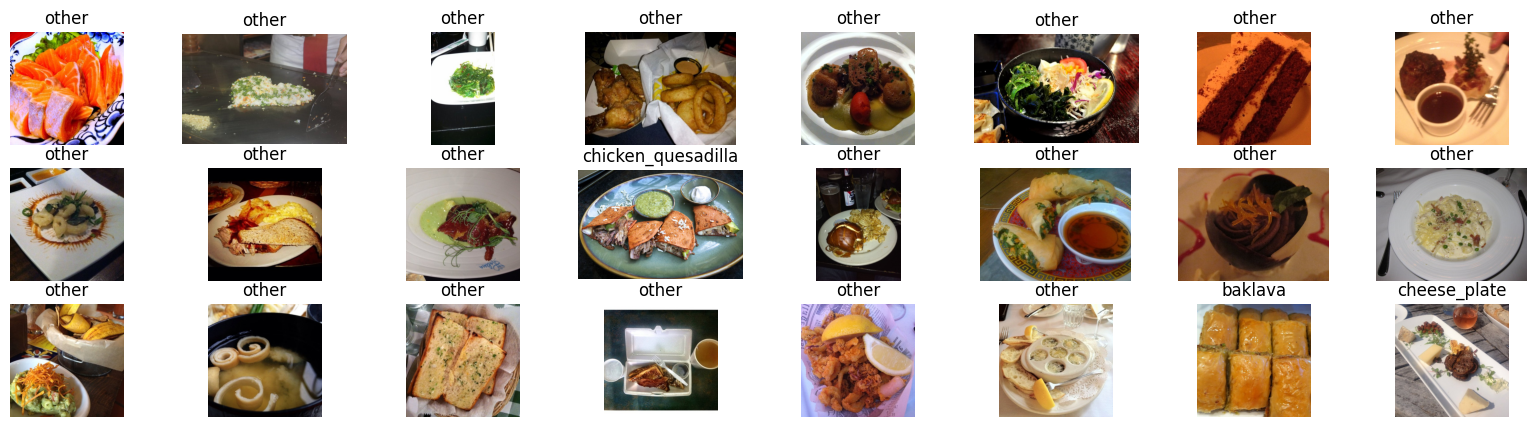

In [11]:
plt.figure(figsize=(20, 5))

num_rows = 3
num_cols = 8


for idx in range(num_rows * num_cols):
    random_idx = np.random.randint(0, train_imgs.shape[0])
    img = plt.imread(train_imgs.path.iloc[random_idx])

    label = train_imgs.label.iloc[random_idx]

    ax = plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

Visualization using a barplot As can be seen when visualizing through using a barplot, only one class dominates the data with 80%, potentially creating issues during the training where if classifying everything as the outlier will yield a 80% accuracy.Visualization using a barplot As can be seen when visualizing through using a barplot, only one class dominates the data with 80%, potentially creating issues during the training where if classifying everything as the outlier will yield a 80% accuracy.

In [12]:
def barplot_vis(imgs_dataframe):# Use the newly integrated Roboto font family for all text.
    fig, ax = plt.subplots()

    new_labels = [row if row in classes_21 else "other" for row in imgs_dataframe.label]
    tmp_imgs_dataframe = imgs_dataframe.copy(deep=True)
    tmp_imgs_dataframe['label'] = new_labels

    grouped_train_imgs = tmp_imgs_dataframe.groupby("label")

    heights = [grouped_train_imgs.get_group(group).shape[0] for group in classes_21]

    # Save the chart so we can loop through the bars below.
    bars = ax.bar(
        x=classes_21,
        height=heights,
        tick_label=classes_21
    )

    # Axis formatting.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)

    # Add text annotations to the top of the bars.
    bar_color = bars[0].get_facecolor()
    percentage_heights = np.array(heights) / sum(heights)
    for idx in range(len(bars)):
      ax.text(
          bars[idx].get_x() + bars[idx].get_width() / 2,
          bars[idx].get_height() + 0.3,
          round(percentage_heights[idx] * 100, 2),
          horizontalalignment='center',
          color=bar_color,
          weight='bold'
      )

    # Add labels and a title.
    ax.set_xlabel('Food Class', labelpad=15, color='#333333')
    ax.set_ylabel('Number of Images', labelpad=15, color='#333333')
    ax.set_title('Visualizing Class Imbalance', pad=15, color='#333333',
                 weight='bold')

    fig.autofmt_xdate(rotation=45)
    fig.set_size_inches(18.5, 4)



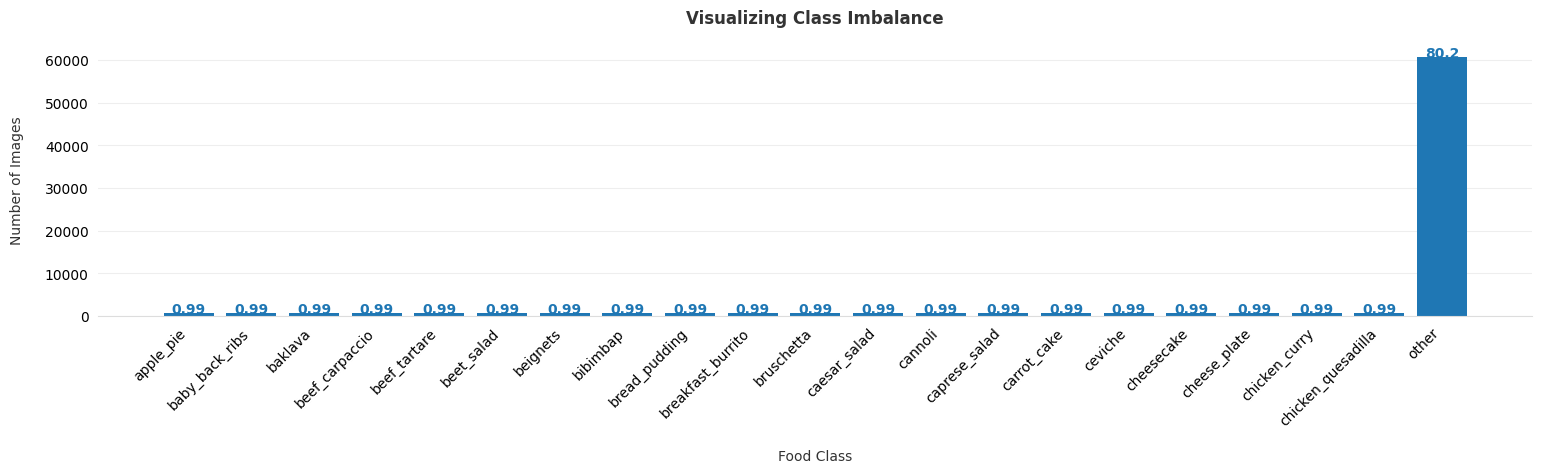

In [13]:
barplot_vis(train_imgs)

# The problem: 
Solving the imbalance problem In the midterm project a pretrained model was used to ensure that the data set works as intended, the solution is to freeze the bottom layers and add one layer at the top that only trains to have 21 output values

# Preparing the Data For Modelling

In [34]:
import torch
import torchvision.transforms as transforms
import torchvision
from torchvision.transforms import AutoAugment, AutoAugmentPolicy, RandomRotation, RandomResizedCrop, RandomHorizontalFlip, ToTensor, Normalize

# Custom CutOut augmentation
class CutOut(object):
    def __init__(self, mask_size, p=0.5):
        self.mask_size = mask_size
        self.p = p

    def __call__(self, img):
        if torch.rand(1).item() > self.p:
            return img

        h, w = img.size(-2), img.size(-1)
        y = torch.randint(0, h, (1,)).item()
        x = torch.randint(0, w, (1,)).item()

        y1 = max(0, y - self.mask_size // 2)
        y2 = min(h, y + self.mask_size // 2)
        x1 = max(0, x - self.mask_size // 2)
        x2 = min(w, x + self.mask_size // 2)

        img[:, y1:y2, x1:x2] = 0
        return img

# Enhanced data augmentation for training with additional transformations
train_transforms = transforms.Compose([
    RandomRotation(45),  # Increased rotation for variability
    RandomResizedCrop(224),
    RandomHorizontalFlip(p=0.7),  # Higher probability for horizontal flip
    AutoAugment(policy=AutoAugmentPolicy.IMAGENET),  # AutoAugment for diverse transformations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # ColorJitter for varied lighting
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    CutOut(mask_size=20, p=0.5)  # CutOut for spatial masking
])

# Standard augmentation for testing
test_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# CutMix implementation for data augmentation within the training loop
def cutmix_data(x, y, alpha=1.0):
    """Applies CutMix augmentation to a batch of data."""
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0])
    target_a = y
    target_b = y[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[rand_index, :, bbx1:bbx2, bby1:bby2]
    return x, target_a, target_b, lam

# Function to calculate random bounding box for CutMix
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


In [35]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    # Set model to training mode
    model.train()

    # Initialize training loss and accuracy
    train_loss, train_acc = 0, 0

    print("--> Training Progress")
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Transfer data to device
        images, labels = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(images)

        # Calculate loss and accumulate
        loss = loss_fn(y_pred, labels)
        train_loss += loss.item()

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Accuracy calculation
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == labels).sum().item() / len(y_pred)

    # Average loss and accuracy per batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc


## Creation of a DataLoader for the Dataset

In [37]:
class Food21(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_name = self.dataframe.path.iloc[idx]
        image = Image.open(img_name)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        label = encoder_21.get_idx(self.dataframe.label.iloc[idx])

        if self.transform:
            image = self.transform(image)

        return image, label

In [38]:
train_dataset = Food21(train_imgs, transform=train_transforms)
test_dataset = Food21(test_imgs, transform=test_transforms)

In [39]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=64)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=64)

# Testing the retrieval of a sample of images
for i in range(10):
    image = train_dataset.__getitem__(i)
    print(encoder_21.get_label(image[1]), image[0].shape)

other torch.Size([3, 224, 224])
other torch.Size([3, 224, 224])
other torch.Size([3, 224, 224])
other torch.Size([3, 224, 224])
other torch.Size([3, 224, 224])
other torch.Size([3, 224, 224])
carrot_cake torch.Size([3, 224, 224])
bibimbap torch.Size([3, 224, 224])
other torch.Size([3, 224, 224])
bibimbap torch.Size([3, 224, 224])


In [42]:
class Head(nn.Module):
    def __init__(self):
        super(Head, self).__init__()

        self.fc = nn.Linear(101, 21)
    
    def forward(self, x):
        return self.fc(x)

In [20]:
random_seeds = [42, 50, 2024]

for seed in random_seeds:
    print(f"Training with seed {seed}...")
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)


  


Training with seed 42...
Training with seed 50...
Training with seed 2024...


In [43]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.checkpoint import checkpoint
import torchinfo
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler
from torch.optim import lr_scheduler
import os

class CheckpointedDenseNet(nn.Module):
    def __init__(self, original_model):
        super(CheckpointedDenseNet, self).__init__()
        # Get feature layers and classifier from the original model
        self.features = original_model.features
        self.classifier = original_model.classifier

    def forward(self, x):
        # Apply checkpointing to feature layers to save memory
        x = checkpoint(self.features, x, use_reentrant=False)
        x = nn.functional.relu(x, inplace=True)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize the original model with pre-trained weights
weights = models.DenseNet201_Weights.IMAGENET1K_V1
original_model = models.densenet201(weights=weights)

# Wrap the original model with gradient checkpointing
model = CheckpointedDenseNet(original_model)

# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Define the additional classifier
classifier = nn.Sequential(
    nn.Linear(1920, 1024),
    nn.LeakyReLU(),
    nn.Linear(1024, 101)
)

# Replace the original classifier with the new classifier
model.classifier = classifier

# Check if the weights are available in the Kaggle input directory
checkpoint_path = "/kaggle/input/food-21-101/pytorch/default/1/food_classifier.pt"
if not os.path.exists(checkpoint_path):
   # # If not found, download from the external URL and save locally
   # import requests
   # url = "https://github.com/Prakhar998/Food-Classification/raw/master/food_classifier.pt"
  #  r = requests.get(url, allow_redirects=True)
    checkpoint_path = "/kaggle/working/food_classifier.pt"
    with open(checkpoint_path, "wb") as f:
        f.write(r.content)

# Load the pre-trained weights
model.load_state_dict(torch.load(checkpoint_path, map_location='cpu', weights_only=True), strict=False)

# Additional classification head if needed
head = nn.Linear(101, 21)

# Combine model with head and wrap with DataParallel
model = nn.DataParallel(nn.Sequential(model, head))

# Summary of the model
torchinfo.summary(model, (1, 3, 224, 224))

# Hyperparameters
num_epochs = 30
lr = 1e-3

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Initialize GradScaler correctly for mixed precision training
scaler = GradScaler('cuda')

# Assume train_loader is already defined elsewhere in your code
# Training loop would use the corrected version of autocast
for images, labels in train_loader:
    images, labels = images.to('cuda'), labels.to('cuda')
    with torch.amp.autocast('cuda'):
        outputs = model(images)
        loss = loss_fn(outputs, labels)


<ipython-input-43-c7cabe2c6c47>:82: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler('cuda')


# Training and Testing The Model¶
## Training the Model

In [44]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  print("--> Training Progress")
  # Loop through data loader data batches
  for batch, (X, y) in enumerate(tqdm(dataloader)):
      # Send data to target device
      images, labels = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(images)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, labels)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


In [45]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      print("--> Testing Progress")
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          # Send data to target device
          images, labels = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(images)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, labels)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)

          test_acc += ((test_pred_labels == labels).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc


In [46]:
import torch
from torch.cuda.amp import autocast, GradScaler

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler._LRScheduler,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          history: dict = None):

    # Initialize the GradScaler for mixed-precision
    scaler = GradScaler()

    # Initialize history if not provided
    if history is None:
        history = {
            "train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": [],
            'best_train_acc': (0, 0),
            "best_model": {}
        }

    # Training loop
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        model.train()  # Set model to training mode
        train_loss, train_acc = 0.0, 0.0

        # Training phase
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass with mixed-precision
            with autocast():
                outputs = model(images)
                loss = loss_fn(outputs, labels)

            # Backward pass with scaled gradients
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            # Accumulate loss and accuracy
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_acc += (predicted == labels).sum().item() / labels.size(0)

        # Average train loss and accuracy
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)

        # Validation phase
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print epoch results
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}\n"
              f"=============================\n")

        # Update history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

        # Save the best model
        if test_acc > max(history["test_acc"], default=0):
            history["best_model"] = model.state_dict()

        # Scheduler step based on validation loss
        scheduler.step(test_loss)

        # Early stopping condition
        if test_acc > 0.98:
            print("Early stopping - Target accuracy reached.")
            break

    return model, history


In [47]:
# Assuming the train function is defined, and you've imported necessary libraries

# Call the train function without the `%` symbol
model, history = train(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,  # If you have a scheduler
    loss_fn=loss_fn,
    epochs=num_epochs,
    device=device,
    history=None  # Optional parameter
)


Epoch 1/30


<ipython-input-46-3c5d8f9d0f81>:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-46-3c5d8f9d0f81>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


--> Testing Progress


100%|██████████| 198/198 [01:54<00:00,  1.73it/s]

Epoch: 1 | train_loss: 0.6578 | train_acc: 0.8512 | test_loss: 0.1944 | test_acc: 0.9363

Epoch 2/30


--> Testing Progress


100%|██████████| 198/198 [01:52<00:00,  1.76it/s]

Epoch: 2 | train_loss: 0.4067 | train_acc: 0.8861 | test_loss: 0.1779 | test_acc: 0.9420

Epoch 3/30


--> Testing Progress


100%|██████████| 198/198 [01:53<00:00,  1.75it/s]

Epoch: 3 | train_loss: 0.3899 | train_acc: 0.8909 | test_loss: 0.1789 | test_acc: 0.9422

Epoch 4/30


--> Testing Progress


100%|██████████| 198/198 [01:53<00:00,  1.75it/s]

Epoch: 4 | train_loss: 0.3813 | train_acc: 0.8939 | test_loss: 0.1520 | test_acc: 0.9509

Epoch 5/30


--> Testing Progress


100%|██████████| 198/198 [01:53<00:00,  1.75it/s]

Epoch: 5 | train_loss: 0.3736 | train_acc: 0.8956 | test_loss: 0.1529 | test_acc: 0.9527

Epoch 6/30


--> Testing Progress


100%|██████████| 198/198 [01:53<00:00,  1.74it/s]

Epoch: 6 | train_loss: 0.3691 | train_acc: 0.8957 | test_loss: 0.1740 | test_acc: 0.9451

Epoch 7/30


--> Testing Progress


100%|██████████| 198/198 [01:52<00:00,  1.76it/s]

Epoch: 7 | train_loss: 0.3663 | train_acc: 0.8960 | test_loss: 0.1437 | test_acc: 0.9533

Epoch 8/30


--> Testing Progress


100%|██████████| 198/198 [01:53<00:00,  1.74it/s]

Epoch: 8 | train_loss: 0.3583 | train_acc: 0.8988 | test_loss: 0.1498 | test_acc: 0.9534

Epoch 9/30


--> Testing Progress


100%|██████████| 198/198 [01:54<00:00,  1.72it/s]

Epoch: 9 | train_loss: 0.3544 | train_acc: 0.8993 | test_loss: 0.1438 | test_acc: 0.9535

Epoch 10/30


--> Testing Progress


100%|██████████| 198/198 [01:53<00:00,  1.74it/s]

Epoch: 10 | train_loss: 0.3545 | train_acc: 0.8993 | test_loss: 0.1397 | test_acc: 0.9546

Epoch 11/30


--> Testing Progress


100%|██████████| 198/198 [01:53<00:00,  1.75it/s]

Epoch: 11 | train_loss: 0.3531 | train_acc: 0.8997 | test_loss: 0.1462 | test_acc: 0.9543

Epoch 12/30


--> Testing Progress


100%|██████████| 198/198 [01:53<00:00,  1.75it/s]

Epoch: 12 | train_loss: 0.3504 | train_acc: 0.9007 | test_loss: 0.1548 | test_acc: 0.9510

Epoch 13/30


--> Testing Progress


100%|██████████| 198/198 [01:52<00:00,  1.76it/s]

Epoch: 13 | train_loss: 0.3464 | train_acc: 0.9004 | test_loss: 0.1457 | test_acc: 0.9542

Epoch 14/30


--> Testing Progress


100%|██████████| 198/198 [01:52<00:00,  1.75it/s]

Epoch: 14 | train_loss: 0.3425 | train_acc: 0.9031 | test_loss: 0.1370 | test_acc: 0.9564

Epoch 15/30


--> Testing Progress


100%|██████████| 198/198 [01:52<00:00,  1.75it/s]

Epoch: 15 | train_loss: 0.3399 | train_acc: 0.9040 | test_loss: 0.1391 | test_acc: 0.9547

Epoch 16/30


--> Testing Progress


100%|██████████| 198/198 [01:53<00:00,  1.75it/s]

Epoch: 16 | train_loss: 0.3407 | train_acc: 0.9019 | test_loss: 0.1413 | test_acc: 0.9559

Epoch 17/30


--> Testing Progress


100%|██████████| 198/198 [01:53<00:00,  1.74it/s]

Epoch: 17 | train_loss: 0.3423 | train_acc: 0.9033 | test_loss: 0.1405 | test_acc: 0.9554

Epoch 18/30


--> Testing Progress


100%|██████████| 198/198 [01:53<00:00,  1.75it/s]

Epoch: 18 | train_loss: 0.3371 | train_acc: 0.9037 | test_loss: 0.1394 | test_acc: 0.9555

Epoch 19/30


--> Testing Progress


100%|██████████| 198/198 [01:53<00:00,  1.74it/s]

Epoch: 19 | train_loss: 0.3135 | train_acc: 0.9096 | test_loss: 0.1220 | test_acc: 0.9607

Epoch 20/30


--> Testing Progress


100%|██████████| 198/198 [01:53<00:00,  1.75it/s]

Epoch: 20 | train_loss: 0.3129 | train_acc: 0.9100 | test_loss: 0.1336 | test_acc: 0.9580

Epoch 21/30


--> Testing Progress


100%|██████████| 198/198 [01:52<00:00,  1.76it/s]

Epoch: 21 | train_loss: 0.3099 | train_acc: 0.9111 | test_loss: 0.1226 | test_acc: 0.9615

Epoch 22/30


--> Testing Progress


100%|██████████| 198/198 [01:52<00:00,  1.76it/s]

Epoch: 22 | train_loss: 0.3061 | train_acc: 0.9111 | test_loss: 0.1157 | test_acc: 0.9629

Epoch 23/30


--> Testing Progress


100%|██████████| 198/198 [01:52<00:00,  1.76it/s]

Epoch: 23 | train_loss: 0.3059 | train_acc: 0.9108 | test_loss: 0.1237 | test_acc: 0.9602

Epoch 24/30


--> Testing Progress


100%|██████████| 198/198 [01:52<00:00,  1.75it/s]

Epoch: 24 | train_loss: 0.3067 | train_acc: 0.9103 | test_loss: 0.1218 | test_acc: 0.9601

Epoch 25/30


--> Testing Progress


100%|██████████| 198/198 [01:53<00:00,  1.75it/s]

Epoch: 25 | train_loss: 0.3067 | train_acc: 0.9114 | test_loss: 0.1161 | test_acc: 0.9623

Epoch 26/30


--> Testing Progress


100%|██████████| 198/198 [01:55<00:00,  1.71it/s]

Epoch: 26 | train_loss: 0.3014 | train_acc: 0.9130 | test_loss: 0.1235 | test_acc: 0.9600

Epoch 27/30


--> Testing Progress


100%|██████████| 198/198 [01:53<00:00,  1.75it/s]

Epoch: 27 | train_loss: 0.2960 | train_acc: 0.9144 | test_loss: 0.1144 | test_acc: 0.9625

Epoch 28/30


--> Testing Progress


100%|██████████| 198/198 [01:53<00:00,  1.74it/s]

Epoch: 28 | train_loss: 0.2938 | train_acc: 0.9140 | test_loss: 0.1134 | test_acc: 0.9638

Epoch 29/30


--> Testing Progress


100%|██████████| 198/198 [01:53<00:00,  1.74it/s]

Epoch: 29 | train_loss: 0.2908 | train_acc: 0.9145 | test_loss: 0.1162 | test_acc: 0.9615

Epoch 30/30


--> Testing Progress


100%|██████████| 198/198 [01:54<00:00,  1.73it/s]

Epoch: 30 | train_loss: 0.2894 | train_acc: 0.9158 | test_loss: 0.1134 | test_acc: 0.9637



In [ ]:
model, history = train(model, train_loader, test_loader, optimizer, loss_fn, epochs=5, device=device, history=history)

In [6]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device, history=None, scheduler=None):
    import torch

    if history is None:
        history = {'train_loss': [], 'test_loss': []}

    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        history['train_loss'].append(avg_train_loss)

        # Evaluation
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(test_dataloader)
        history['test_loss'].append(avg_test_loss)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

        if scheduler:
            scheduler.step()

    return model, history


In [8]:
import torch
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Example: define model
input_size = 784   # e.g. for flattened 28x28 images (like MNIST)
hidden_size = 128
num_classes = 10   # number of output classes

model = SimpleNN(input_size, hidden_size, num_classes)


In [9]:
import torch.optim as optim

# Example optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Example: if using GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [11]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set batch size
batch_size = 64

# Define image transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load training and testing datasets
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 55.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.69MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 15.2MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.47MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [13]:
for inputs, labels in train_loader:
    print(inputs.shape)  # e.g., torch.Size([64, 1, 28, 28]) for MNIST
    break


torch.Size([64, 1, 28, 28])


In [14]:
for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    inputs = inputs.view(inputs.size(0), -1)  # Flatten the input
    ...


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Dummy data (replace with your own)
X = np.random.rand(2000, 28).astype(np.float32)  # 28 features
y = np.random.randint(0, 10, size=(2000,))       # 10 classes

# Convert to PyTorch tensors
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y)

# Create Dataloaders
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset, batch_size=64)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model definition for 28 input features
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = SimpleNN().to(device)

# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Train function
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device, history=None, scheduler=None):
    if history is None:
        history = {'train_loss': [], 'test_loss': []}

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        history['train_loss'].append(avg_train_loss)

        # Evaluation
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(test_dataloader)
        history['test_loss'].append(avg_test_loss)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

        if scheduler:
            scheduler.step()

    return model, history

# Train the model
model, history = train(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device
)


Epoch [1/5] - Train Loss: 2.3101, Test Loss: 2.2990
Epoch [2/5] - Train Loss: 2.2995, Test Loss: 2.2941
Epoch [3/5] - Train Loss: 2.2968, Test Loss: 2.2893
Epoch [4/5] - Train Loss: 2.2933, Test Loss: 2.2844
Epoch [5/5] - Train Loss: 2.2879, Test Loss: 2.2796


In [17]:
model, history = train(model, train_loader, test_loader, optimizer, loss_fn, epochs=3, device=device, history=history)

Epoch [1/3] - Train Loss: 2.2844, Test Loss: 2.2756
Epoch [2/3] - Train Loss: 2.2799, Test Loss: 2.2690
Epoch [3/3] - Train Loss: 2.2745, Test Loss: 2.2661


In [18]:
model, history = train(model, train_loader, test_loader, optimizer, loss_fn, epochs=1, device=device, history=history)


Epoch [1/1] - Train Loss: 2.2719, Test Loss: 2.2608


## Viewing the Learning History

In [19]:
import matplotlib.pyplot as plt

def plot_history(history):
    loss = history['train_loss']
    accuracy = history['train_acc']
    val_loss = history['test_loss']
    val_accuracy = history['test_acc']
    x = range(len(loss))

    plt.figure(figsize=(12, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, label='Training acc', color='#03045e', linewidth=2)
    if val_accuracy:
        plt.plot(x, val_accuracy, label='Validation acc', color='#48cae4', linewidth=2)
    if "best_train_acc" in history:
        best_epoch, best_acc = history["best_train_acc"]
        plt.scatter(best_epoch, best_acc, label='Best train acc', color='black', s=50)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, label='Training loss', color='#03045e', linewidth=2)
    if val_loss:
        plt.plot(x, val_loss, label='Validation loss', color='#48cae4', linewidth=2)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:

plot_history(history)


# Assessing The Result

## Getting the Accuracy

In [20]:
def evaluate(model, dataloader):

  random = np.random.randint(0, len(dataloader))

  with torch.no_grad():
    model.eval()
    n_correct = 0
    n_samples = 0

    for images, labels in tqdm(dataloader):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)

      preds = torch.argmax(torch.softmax(outputs, 1), 1)

      n_samples += labels.shape[0]
      n_correct += (preds==labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(acc)

In [22]:
from tqdm import tqdm

evaluate(model,test_loader)

100%|██████████| 32/32 [00:00<00:00, 293.69it/s]

17.3


## Assessing the Results Visually

In [23]:
def visually_evaluate(model, data_df):
    num_rows = 3
    num_cols = 6

    random_idx = np.random.randint(0, data_df.shape[0], num_rows*num_cols)

    # Retrieve a number of images from the dataset.
    imgs, labels = data_df.iloc[random_idx], data_df.iloc[random_idx].label
    eval_dataset = Food21(imgs, transform=test_transforms)
    eval_loader = DataLoader(eval_dataset, batch_size=num_rows*num_cols, shuffle=False)
    eval_set = next(iter(eval_loader))

    # Get predictions from model.
    model.eval()
    preds = model(eval_set[0].to(device))
    preds = torch.argmax(torch.softmax(preds, dim=1), dim=1)

    str_preds = []
    for idx in range(len(preds)):
        str_preds.append(encoder_21.get_label(preds[idx]))

    plt.figure(figsize=(20, 8))

    num_matches = 0
    for idx in range(num_rows * num_cols):
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        plt.axis("off")

        img = plt.imread(imgs.path.iloc[idx])
        plt.imshow(img)

        title = str(labels.iloc[idx]) + " : " + str_preds[idx]
        title_obj = plt.title(title, fontdict={'fontsize':13})

        if labels.iloc[idx] == str_preds[idx]:
            num_matches += 1
            plt.setp(title_obj, color='g')
        else:
            plt.setp(title_obj, color='r')

        acc = num_matches / (idx + 1)
    print("Prediction accuracy on test images: ", int(100 * acc) / 100)

    return


In [25]:
# Get a batch of test images
test_imgs, test_labels = next(iter(test_loader))
test_imgs = test_imgs.to(device)


## Saving the model

In [28]:
import torch

# Define the path to save the model
model_save_path = '/kaggle/working/food_classifier.pt'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /kaggle/working/food_classifier.pt
